# Traffic Sign Classification

---
## 1. Load German Traffic Sign Dataset

In [3]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '.\\data\\train.p'
validation_file= '.\\data\\valid.p'
testing_file = '.\\data\\test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## 2. Dataset Exploration

### 2.1 Dataset Summary

In [4]:
import numpy as np
import math
import csv

#Number of training examples
n_train = y_train.shape[0]

#Number of validation examples
n_validation = y_valid.shape[0]

#Number of testing examples.
n_test = y_test.shape[0]

#Traffic Sign Image shape
image_shape = X_train[0].shape

#Number of unique classes
n_classes = np.unique(y_train).shape[0]

#List of traffic sign labels names
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader, infile)
    traffic_sign_labels = [rows[1] for rows in reader]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### 2.2 Dataset Visualization

Let's plot 10 sequential images starting randomly somewhere in the training split..



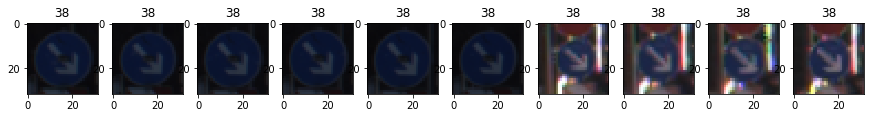

Now, let's visualize the reprentation of each label in all three splits


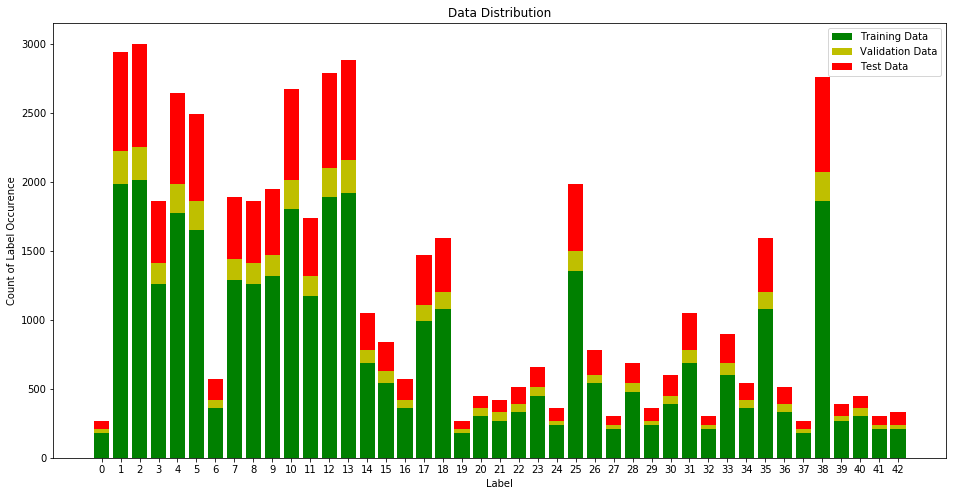

Let's quantify which labels need to be augmented by setting the threshold to be 1500 training samples

The following 35 labels have less than 1500 training samples and need to be augmented:

[0, 3, 6, 7, 8, 9, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 42]
Image Label: 38 - Keep right


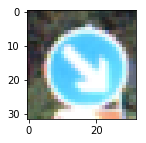

In [27]:
import matplotlib.pyplot as plt
import random
import itertools
from collections import Counter

# Visualizations will be shown in the notebook.
%matplotlib inline

#Determine count of each label in splits
train_set = Counter(y_train)
valid_set = Counter(y_valid)
test_set = Counter(y_test)

print("Let's plot 10 sequential images starting randomly somewhere in the training split..\n")

index = random.randint(0, len(X_train))
n_images = 10
image = X_train[index:index+n_images]
image_labels = y_train[index:index+n_images]
plt.figure(figsize=(15,5))
for i in range(n_images):
    plt.subplot(1,n_images,i+1)
    plt.imshow(image[i])
    plt.title(y_train[index+i])
    #print('Image Labels:', y_train[index+i], "-", traffic_sign_labels[y_train[index+i]])
#plt.savefig('.\\graphics\\label-images.png')
plt.show()

#Plot histogram of labels in each set
print("Now, let's visualize the reprentation of each label in all three splits")
plt.figure(figsize=(16,8))
plt.title('Data Distribution')
train_bar = plt.bar(range(len(train_set)), train_set.values(), color = 'g')
valid_bar = plt.bar(range(len(valid_set)), valid_set.values(), color = 'y', bottom = train_set.values())
test_bar = plt.bar(range(len(test_set)), test_set.values(), color = 'r', bottom = (train_set + valid_set).values())

plt.xticks(range(len(train_set)), train_set.keys())
plt.xlabel('Label')
plt.ylabel('Count of Label Occurence')
plt.legend([train_bar, valid_bar, test_bar], ['Training Data', 'Validation Data', 'Test Data'])
#plt.savefig('.\\graphics\\datahistogram.png')
plt.show()

n_threshold = 1500
print("Let's quantify which labels need to be augmented by setting the threshold to be {:d} training samples\n"
      .format(n_threshold))
#Identify which labels need to be augmented
labels_to_augment = []
for key in train_set.keys():
    if(train_set[key] < n_threshold):
        labels_to_augment.append(key)
print("The following {:d} labels have less than {:d} training samples and need to be augmented:\n"
      .format(len(labels_to_augment), n_threshold))
print(labels_to_augment)

#Plot an image given a label
label2plot = 38
images2plot = X_train[np.where(y_train == label2plot)]
random_index = np.random.randint(0, images2plot.shape[0])
print('Image Label:', label2plot, "-", traffic_sign_labels[label2plot])
fig = plt.figure(figsize=(2,2))
fig = plt.imshow(images2plot[random_index])
#plt.savefig('.\\graphics\\y-flipped-img.png')

---
## 3. Data Processing

### 3.1 Data Processing/Augmentation Functions

In [8]:
#Declare pre-processing functions

from tqdm import tqdm
from skimage import transform
import cv2

#Covert RGB image to grayscale
def grayscale(img_set):
    gray_img_set = []
    for img in img_set:
            gray_img_set.append(cv2.cvtColor(img, cv2.COLOR_RGB2GRAY))
    return gray_img_set

#Perform histogram equalization using basic algorithm on grayscale images
def equalize(img_set):
    equal_img_set = []
    for img in img_set:
        equal_img_set.append(np.expand_dims(cv2.equalizeHist(img), axis = 2))
    return equal_img_set

#Perform histogram equalization using CLAHE algorithm on grayscale images
def clahe_equalize(img_set):
    clahe_img_set = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    for img in img_set:
        clahe_img_set.append(np.expand_dims(clahe.apply(img), axis = 2))
    return clahe_img_set

#Perform histogram equalization using CLAHE algorithm on RGB->YUV->RGB images
def clahe_equalize_RGB(img_set):
    clahe_RGB_img_set = []
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
    for img in img_set:
        y, u, v = cv2.split(cv2.cvtColor(img, cv2.COLOR_RGB2YUV))
        y = clahe.apply(y)
        img = cv2.merge((y,u,v))
        img = cv2.cvtColor(img, cv2.COLOR_YUV2RGB)
        clahe_RGB_img_set.append(img)
    return clahe_RGB_img_set

#Merge RGB and gray channels to create image set of depth 4
def merge_channels(img_gray_set, img_RGB_set):
    merge_set = []
    assert(len(img_RGB_set) == len(img_gray_set))
    for img1, img2 in zip(img_gray_set, img_RGB_set):
        img = cv2.merge((img1, img2))
        merge_set.append(img)
    return merge_set

#Normalize image set using mean/std of entire image set
def normalize(img_set, mean, std):
    norm_img_set = []
    for img in tqdm(img_set, total = len(img_set)):
        norm_img_set.append((img - mean)/std)

    return norm_img_set

In [9]:
#Declare augmentation functions

#References: 
#https://github.com/vxy10/ImageAugmentation 
#https://medium.com/@vivek.yadav/improved-performance-of-deep-learning-neural-network-models-on-traffic-sign-classification
#        -using-6355346da2dc
#https://navoshta.com/traffic-signs-classification/
#https://github.com/vxy10/ImageAugmentation


def transform_image(img, rt_range, xlate_range):
    #Define Transformations - rotation and translation
    pixels_x, pixels_y, channels = img.shape    
    rt_angle = np.random.uniform(rt_range) - rt_range/2
    xlate_x = np.random.uniform(xlate_range) - xlate_range/2
    xlate_y = np.random.uniform(xlate_range) - xlate_range/2
    
    M_rot = cv2.getRotationMatrix2D((pixels_y/2, pixels_x/2), rt_angle, 1)
    M_xlate = np.float32([[1,0,xlate_x],[0,1,xlate_y]])
    
    #Transform image
    img = cv2.warpAffine(img, M_xlate, (pixels_y, pixels_x))
    img = cv2.warpAffine(img, M_rot, (pixels_y, pixels_x))
    
    return img

def augment_set(X_data, y_data, labels, threshold, rt_range, xlate_range):
    
    #Declare all variables
    images_dict = {}
    n_imgs = 0 #total # of images that will be perturbed
    pixels_x, pixels_y, channels = X_data.shape[1:4]
    n_aug_imgs = {} #holds # of images that need to be created for each label
    
    #Determine indices of images that need to be augmented and their corresponding labels
    for label in labels:
        images_dict[label] = X_data[np.where(y_data == label)]
        n_aug_imgs[label] =  threshold - images_dict[label].shape[0]
        n_imgs += images_dict[label].shape[0]
        
    #Determine how many perturbed images need to be created for each label to meet the threshold
    print ("# of images available to be perturbed:", n_imgs)
    print("# of images to be created per label", n_aug_imgs)
    print("Total # of images to be created:", sum(n_aug_imgs.values()))
    
    #Create empty array to hold perturbed images
    new_images = np.empty([sum(n_aug_imgs.values()), pixels_x, pixels_y, channels], dtype = np.uint8)
    new_labels = np.empty([sum(n_aug_imgs.values())], dtype = int)
    #print("The shapes of the new arrays are:", new_images.shape, new_labels.shape)
    
    #Loop through labels/image arrays, determine # of perturbations for each image in label then perturb image
    offset = 0
    for label, img_array in tqdm(images_dict.items(), total = len(labels)):
        #print("The image counter has been reset, starting label", label)
        new_img_count = 0
        n_pertubations = math.ceil(n_aug_imgs[label]/images_dict[label].shape[0])
        #print("Labels {:d} has {:d} images and {:d} new images need to be created"
              #.format(label, images_dict[label].shape[0], n_aug_imgs[label]))
        for img_index, img in enumerate(img_array):
            #print("We will create {:d} pertubations for this image.".format(n_pertubations))
                
            #create the desired number of pertubations
            for i in range(n_pertubations):
                #Create the new image and label
                new_images[i+img_index*n_pertubations+offset] = transform_image(img, rt_range, xlate_range)
                #print("The new label is", label, "at index", i+img_index*n_pertubations+offset)
                new_labels[i+img_index*n_pertubations+offset] = label
                new_img_count += 1
                
                if (new_img_count == n_aug_imgs[label]):
                    break
            
            if (new_img_count == n_aug_imgs[label]):
                break
        
        offset += n_aug_imgs[label]
        #print("{:d} new images created for label {:d}".format(new_img_count, label))
        #print("The offset is now {:d}\n".format(offset))
        
        aug_X_data = np.concatenate((X_data, new_images), 0)
        aug_y_data = np.concatenate((y_data, new_labels), 0)


    return (aug_X_data, aug_y_data) 

#Do image mirroring and rotations on labels that are invariant to the operation
def basic_augment(X_data, y_data, xflip, yflip, rot120):    
   
    #Define variables and dictionaries
    xflip_dict = {}
    yflip_dict = {}
    rot_dict = {}
    n_xflip_imgs, n_yflip_imgs, n_rot_imgs = 0, 0, 0
    
    #Setup up rotation matrices
    pixels_x, pixels_y, channels = X_data.shape[1:4]
    M1 = cv2.getRotationMatrix2D((pixels_y/2,pixels_x/2), 120, 1)
    M2 = cv2.getRotationMatrix2D((pixels_y/2,pixels_x/2), 240, 1)
    
    #Populate dictonary with images to be operated on with key = label
    for old_label, new_label in xflip:
        xflip_dict[old_label] = X_data[np.where(y_data == old_label)]
        n_xflip_imgs += xflip_dict[old_label].shape[0]
    
    for old_label, new_label in yflip:
        yflip_dict[old_label] = X_data[np.where(y_data == old_label)]
        n_yflip_imgs += yflip_dict[old_label].shape[0]
  
    for old_label, new_label in rot120:
        rot_dict[old_label] = X_data[np.where(y_data == old_label)]
        n_rot_imgs += rot_dict[old_label].shape[0]
    
    #Create empty arrays to hold new images and their corresponding labels
    xflip_images = np.empty([n_xflip_imgs, pixels_x, pixels_y, channels], dtype = np.uint8)
    xflip_labels = np.empty([n_xflip_imgs], dtype = int)
    yflip_images = np.empty([n_yflip_imgs, pixels_x, pixels_y, channels], dtype = np.uint8)
    yflip_labels = np.empty([n_yflip_imgs], dtype = int)
    rot_images = np.empty([2*n_rot_imgs, pixels_x, pixels_y, channels], dtype = np.uint8)
    rot_labels = np.empty([2*n_rot_imgs], dtype = int)

    #Perform xflips, yflips and 120deg, 240deg rotations
    offset = 0
    for label, img_array in xflip_dict.items():
        if img_array.shape[0] != 0:
            for index, img in enumerate(img_array):
                xflip_images[index+offset] = cv2.flip(img,0)
                xflip_labels[index+offset] = label
            offset += img_array.shape[0]
    
    offset = 0
    for label, img_array in yflip_dict.items():
        if img_array.shape[0] != 0:
            for index, img in enumerate(img_array):
                yflip_images[index+offset] = cv2.flip(img,1)
                yflip_labels[index+offset] = yflip[np.where(yflip[:,0] == label),1][0][0]
            offset += img_array.shape[0]
    
    offset = 0
    for label, img_array in rot_dict.items():
        if img_array.shape[0] != 0:
            for index, img in enumerate(img_array):
                rot_images[index+offset] = cv2.warpAffine(img, M1, (pixels_y,pixels_x))
                rot_images[index+n_rot_imgs+offset] = cv2.warpAffine(img, M2, (pixels_y,pixels_x))
                rot_labels[index+offset] = label
                rot_labels[index+n_rot_imgs+offset] = label
            offset += img_array.shape[0]
    
    #Append arrays and return new training data set
    
    aug_X_data = np.concatenate((X_data, xflip_images, yflip_images, rot_images), 0)
    aug_y_data = np.concatenate((y_data, xflip_labels, yflip_labels, rot_labels), 0)
    print("Number of x-flipped images:", xflip_images.shape[0])
    print("Number of y-flipped images:", yflip_images.shape[0])
    print("Number of rotated images (2x the input):", rot_images.shape[0])
    print("Total # of appended images:", xflip_images.shape[0] + yflip_images.shape[0] + rot_images.shape[0])
    print("Original training data set had {:d} images".format(X_data.shape[0]))
    print("Augmented training data set has {:d} images\n".format(aug_X_data.shape[0]))
        
    return (aug_X_data, aug_y_data)

Number of x-flipped images: 990
Number of y-flipped images: 5069
Number of rotated images (2x the input): 600
Total # of appended images: 6659
Original training data set had 34799 images
Augmented training data set has 41458 images

Lets visualize the new augmented data set. Some of the lables have been augmented but clearly, more augmentation is required:


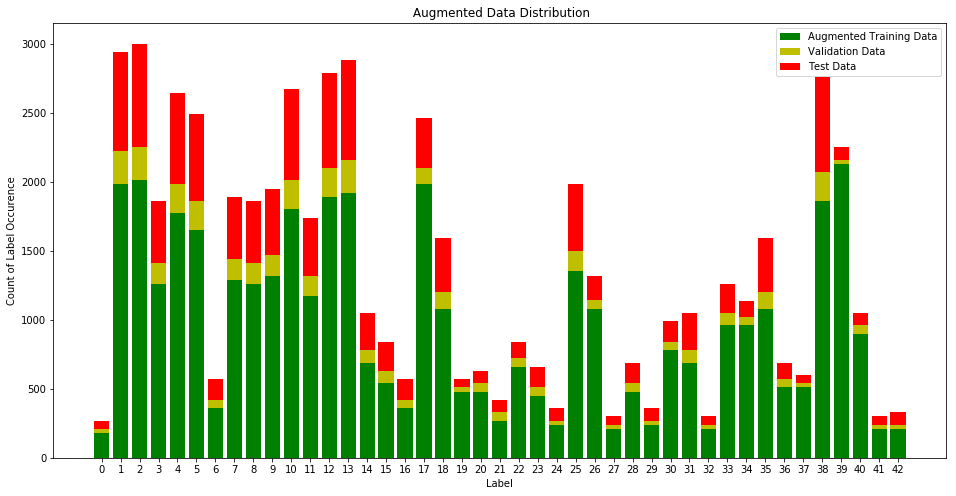

The following 33 labels have less than 1500 training samples and need to be augmented:

[0, 3, 6, 7, 8, 9, 11, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 41, 42]
# of images available to be perturbed: 22468
# of images to be created per label {0: 1320, 3: 240, 6: 1140, 7: 210, 8: 240, 9: 180, 11: 330, 14: 810, 15: 960, 16: 1140, 18: 420, 19: 1020, 20: 1020, 21: 1230, 22: 840, 23: 1050, 24: 1260, 25: 150, 26: 420, 27: 1290, 28: 1020, 29: 1260, 30: 720, 31: 810, 32: 1290, 33: 541, 34: 541, 35: 420, 36: 990, 37: 990, 40: 600, 41: 1290, 42: 1290}
Total # of images to be created: 27032


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:06<00:00,  5.08it/s]


The final augmented training set has 68490 images


In [10]:
#Do Preliminary Augmentation on Dataset (i.e. image mirroring and simple rotations)

#Identify which labels can be flipped horizontally/vertically and determine the new label if changed [oldlabel, new label].
#This is not an exhaustive list since not all labels that can be flipped require augmentation

labels_x_flip = np.array([[17,17]])
labels_y_flip = np.array([[19,20], [20,19], [22,22], [26,26], [30,30], [33,34], [34,33], [36,37], [37,36], [38,39]])
labels_rot_120 = np.array([[40,40]])

X_train_aug, y_train_aug = basic_augment(X_train, y_train, labels_x_flip, labels_y_flip, labels_rot_120)

print("Lets visualize the new augmented data set. Some of the lables have been augmented but" 
      " clearly, more augmentation is required:")

#Plot histogram of labels in each set
aug_train_set = Counter(y_train_aug)
valid_set = Counter(y_valid)
test_set = Counter(y_test)

plt.figure(figsize=(16,8))
plt.title(' Augmented Data Distribution')
aug_train_bar = plt.bar(range(len(aug_train_set)), aug_train_set.values(), color = 'g')
valid_bar = plt.bar(range(len(valid_set)), valid_set.values(), color = 'y', bottom = aug_train_set.values())
test_bar = plt.bar(range(len(test_set)), test_set.values(), color = 'r', bottom = (aug_train_set + valid_set).values())

plt.xticks(range(len(aug_train_set)), aug_train_set.keys())
plt.xlabel('Label')
plt.ylabel('Count of Label Occurence')
plt.legend([aug_train_bar, valid_bar, test_bar], ['Augmented Training Data', 'Validation Data', 'Test Data'])
#plt.savefig('.\\graphics\\AugDataHistogram.png')
plt.show()

#Identify which labels need to be augmented
labels_to_augment = []
n_threshold = 1500
for key in aug_train_set.keys():
    if(aug_train_set[key] < n_threshold):
        labels_to_augment.append(key)
print("The following {:d} labels have less than {:d} training samples and need to be augmented:\n"
      .format(len(labels_to_augment), n_threshold))
print(labels_to_augment)

#Perform additional augmentation to get under-represented labels in the training set up to the threshold
rt_range = 15
xlate_range = 5
X_train_aug2, y_train_aug2 = augment_set(X_train_aug, y_train_aug, labels_to_augment, 
                                         n_threshold, rt_range, xlate_range)

print("The final augmented training set has {:d} images".format(X_train_aug2.shape[0]))

### 3.2 Perform Data Augmentation

Let's plot that histogram again...


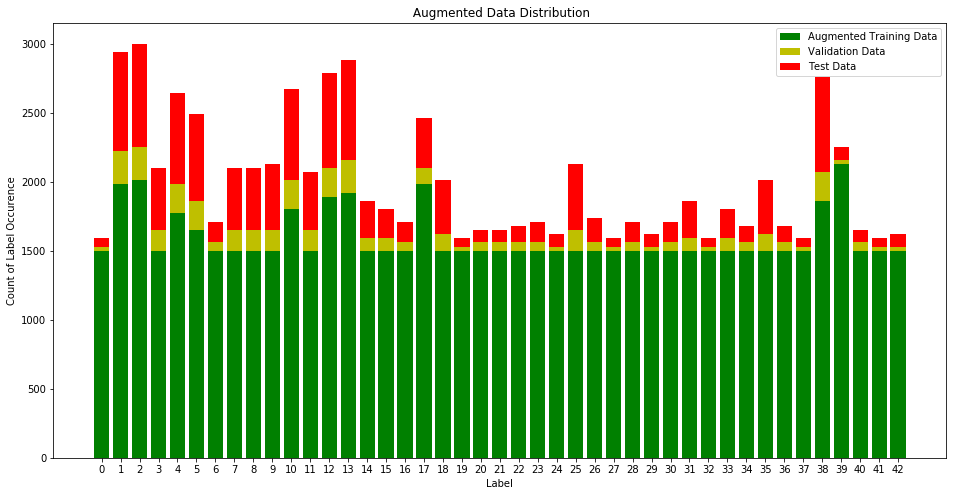

The data distribution is much more balanced. Let's take a look at some of the newly transformed images:


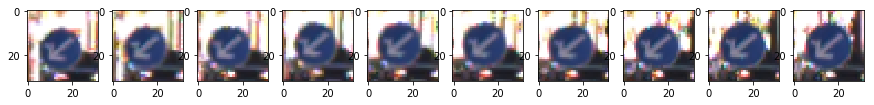

In [31]:
print("Let's plot that histogram again...")

aug_train_set = Counter(y_train_aug2)
valid_set = Counter(y_valid)
test_set = Counter(y_test)

plt.figure(figsize=(16,8))
plt.title(' Augmented Data Distribution')
aug_train_bar = plt.bar(range(len(aug_train_set)), aug_train_set.values(), color = 'g')
valid_bar = plt.bar(range(len(valid_set)), valid_set.values(), color = 'y', bottom = aug_train_set.values())
test_bar = plt.bar(range(len(test_set)), test_set.values(), color = 'r', bottom = (aug_train_set + valid_set).values())

plt.xticks(range(len(aug_train_set)), aug_train_set.keys())
plt.xlabel('Label')
plt.ylabel('Count of Label Occurence')
plt.legend([aug_train_bar, valid_bar, test_bar], ['Augmented Training Data', 'Validation Data', 'Test Data'])
#plt.savefig('.\\graphics\\FinalDataHistogram.png')
plt.show()

print("The data distribution is much more balanced. Let's take a look at some of the newly transformed images:")
index = random.randint(34799, len(X_train_aug2))
n_images = 10
image = X_train_aug2[index:index+n_images]
image_labels = y_train_aug2[index:index+n_images]
plt.figure(figsize=(15,3))
for i in range(n_images):
    plt.subplot(1,n_images,i+1)
    plt.imshow(image[i])
plt.savefig('.\\graphics\\augmentation.png')
plt.show()

In [13]:
#Call Pre-Processing functions

#Create equalized grayscale images
X_train_gray = grayscale(X_train_aug2)
X_valid_gray = grayscale(X_valid)
X_test_gray = grayscale(X_test)

X_train_clahe = clahe_equalize(X_train_gray)
X_valid_clahe = clahe_equalize(X_valid_gray)
X_test_clahe = clahe_equalize(X_test_gray)

#Create equalized RGB images
X_train_clahe_RGB = clahe_equalize_RGB(X_train_aug2)
X_valid_clahe_RGB = clahe_equalize_RGB(X_valid)
X_test_clahe_RGB = clahe_equalize_RGB(X_test)

#Merge images
X_train_merge = merge_channels(X_train_clahe, X_train_clahe_RGB)
X_valid_merge = merge_channels(X_valid_clahe, X_valid_clahe_RGB)
X_test_merge = merge_channels(X_test_clahe, X_test_clahe_RGB)

#Compute mean and standard for training set and apply to all splits
#Ref: http://cs231n.github.io/neural-networks-2/
#mean = np.mean(X_train_clahe)
#std = np.std(X_train_clahe)

mean = np.mean(X_train_merge)
std = np.std(X_train_merge)

#Normalize images in each split
X_train_processed = normalize(X_train_merge, mean, std)
X_valid_processed = normalize(X_valid_merge, mean, std)
X_test_processed = normalize(X_test_merge, mean, std)

y_train_processed = y_train_aug2

100%|█████████████████████████████████████████████████████████████████████████| 12630/12630 [00:00<00:00, 19371.53it/s]


Index: 35242
Image Label: 17 - No entry


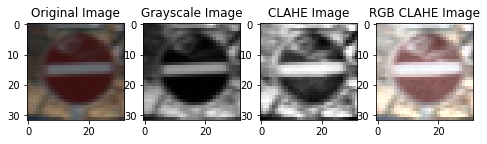

In [15]:
#Check Pre-Processing
#index = random.randint(34799, len(X_train_aug2))
index = 35242
image = X_train_aug2[index]
print("Index:", index)
image_gray = X_train_gray[index]
image_processed = X_train_clahe[index]
RGB_enhanced = X_train_clahe_RGB[index]

plt.figure(figsize=(8,2))
plt.subplot(1,4,1)
plt.title('Original Image')
plt.imshow(image)
plt.subplot(1,4,2)
plt.title('Grayscale Image')
plt.imshow(image_gray.squeeze(), cmap = 'gray')
plt.subplot(1,4,3)
plt.title('CLAHE Image')
plt.imshow(image_processed.squeeze(), cmap = 'gray')
plt.subplot(1,4,4)
plt.title('RGB CLAHE Image')
plt.imshow(RGB_enhanced)
plt.savefig('.\\graphics\\image-processing.png')
print('Image Label:', y_train_aug2[index], "-", traffic_sign_labels[y_train_aug2[index]])

---
## 4. Model Architecture

In [3]:
#Import all libraries
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle
import math

In [5]:
#Implement LeNet-5 Architecture - Use LeNet Lab as starting point

def LeNet5(x):
    mu = 0
    sigma = 0.1
    
    #Define Weights & Biases - change depth of wc1 and wc2 from 1,6 - 4,10, 6,16 - 10,20, wd1 from 400 to 500
    weights = {
                'wc1':tf.Variable(tf.truncated_normal([5,5,4,10], mu, sigma)),
                'wc2':tf.Variable(tf.truncated_normal([5,5,10,20], mu, sigma)),
                'wd1':tf.Variable(tf.truncated_normal([500,120], mu, sigma)),
                'wd2':tf.Variable(tf.truncated_normal([120,84], mu, sigma)),
                'wd3':tf.Variable(tf.truncated_normal([84,43], mu, sigma))
    }
    #change bc1 and bc2 from 6,16 to 10,20
    bias = {
                'bc1':tf.Variable(tf.truncated_normal([10], mu, sigma)), 
                'bc2':tf.Variable(tf.truncated_normal([20], mu, sigma)),
                'bd1':tf.Variable(tf.truncated_normal([120], mu, sigma)),
                'bd2':tf.Variable(tf.truncated_normal([84], mu, sigma)),
                'bd3':tf.Variable(tf.truncated_normal([43], mu, sigma))
    }
    
    #Include L2 regularization 
    L2_norm = tf.nn.l2_loss(weights['wc1']) + tf.nn.l2_loss(weights['wc2']) + \
                tf.nn.l2_loss(weights['wd1']) + tf.nn.l2_loss(weights['wd2']) + tf.nn.l2_loss(weights['wd3'])
    
    stride_conv = [1,1,1,1]
    stride_pool = [1,2,2,1]
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6 x10.
    conv1 = tf.nn.conv2d(x, weights['wc1'], strides = stride_conv, padding = 'VALID')
    conv1 = tf.nn.bias_add(conv1, bias['bc1'])

    # Activation. - Use ReLU
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6 x10.
    conv1 = tf.nn.max_pool(conv1, ksize = stride_pool, strides = stride_pool, padding = 'VALID')
    
    # Layer 2: Convolutional. Output = 10x10x16 x20.
    conv2 = tf.nn.conv2d(conv1, weights['wc2'], strides = stride_conv, padding = 'VALID')
    conv2 = tf.nn.bias_add(conv2, bias['bc2'])
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16 x20. Output = 5x5x16 x20.
    conv2 = tf.nn.max_pool(conv2, ksize = stride_pool, strides = stride_pool, padding = 'VALID')

    # Flatten. Input = 5x5x16. Output = 400 to 500.
    fc1 = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400 to 500. Output = 120.
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), bias['bd1'])
    
    # Activation.
    fc1 = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, keep_prob)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), bias['bd2'])
    
    # TODO: Activation.
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['wd3']), bias['bd3'])
    
    return logits, L2_norm, conv1, conv2, fc1, fc2
    

### 4.1 Model Training

In [10]:
#Define Variables for model training - change x from depth 1 to 4
x = tf.placeholder(tf.float32, (None, 32, 32, 4))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

#Define hyperparameters
RATE = 0.0005
keep_prob = tf.placeholder(tf.float32)
EPOCHS = 15
BATCH_SIZE = 128
beta = 0.001

#Define Training Pipeline
logits, L2_norm, conv1, conv2, fc1, fc2 = LeNet5(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = RATE)
training_operation = optimizer.minimize(loss_operation + beta*L2_norm)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [11]:
#Accuracy & loss evaluation function
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    n_batches = math.ceil(num_examples/BATCH_SIZE)
    total_accuracy = 0
    total_loss = 0
    sess = tf.get_default_session()
    print("Validating & calculating loss...")
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
        total_loss += (loss * len(batch_x))
    return (total_loss / num_examples, total_accuracy / num_examples)

In [14]:
#Create Session & conduct training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_processed)
    n_batches = math.ceil(num_examples/BATCH_SIZE)
    
    train_accuracy = []
    valid_accuracy = []
    train_loss = []
    valid_loss = []
    
    print("Training Model...")
    for i in tqdm(range(EPOCHS), total = EPOCHS):
        X_train_processed, y_train_processed = shuffle(X_train_processed, y_train_processed)
        print("Training on batches...")
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_processed[offset:end], y_train_processed[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
        
        #Calculate losses & accuracies
        training_loss, training_accuracy = evaluate(X_train_processed, y_train_processed)
        validation_loss, validation_accuracy = evaluate(X_valid_processed, y_valid)
        train_accuracy.append(training_accuracy*100)
        valid_accuracy.append(validation_accuracy*100)
        train_loss.append(training_loss)
        valid_loss.append(validation_loss)
        
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './LeNet5_Run3')
    print("Training Completed!")

Training Model...


  0%|                                                                                           | 0/15 [00:00<?, ?it/s]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 1 ...
Training Accuracy = 0.840
Validation Accuracy = 0.807



  7%|█████▍                                                                            | 1/15 [02:39<37:08, 159.21s/it]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 2 ...
Training Accuracy = 0.926
Validation Accuracy = 0.895



 13%|██████████▉                                                                       | 2/15 [04:59<33:16, 153.56s/it]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 3 ...
Training Accuracy = 0.955
Validation Accuracy = 0.921



 20%|████████████████▍                                                                 | 3/15 [07:11<29:25, 147.09s/it]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 4 ...
Training Accuracy = 0.970
Validation Accuracy = 0.936



 27%|█████████████████████▊                                                            | 4/15 [09:27<26:20, 143.67s/it]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 5 ...
Training Accuracy = 0.978
Validation Accuracy = 0.944



 33%|███████████████████████████▎                                                      | 5/15 [11:40<23:26, 140.67s/it]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 6 ...
Training Accuracy = 0.983
Validation Accuracy = 0.957



 40%|████████████████████████████████▊                                                 | 6/15 [13:50<20:37, 137.45s/it]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 7 ...
Training Accuracy = 0.987
Validation Accuracy = 0.959



 47%|██████████████████████████████████████▎                                           | 7/15 [16:03<18:07, 135.90s/it]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 8 ...
Training Accuracy = 0.988
Validation Accuracy = 0.963



 53%|███████████████████████████████████████████▋                                      | 8/15 [18:16<15:45, 135.02s/it]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 9 ...
Training Accuracy = 0.991
Validation Accuracy = 0.964



 60%|█████████████████████████████████████████████████▏                                | 9/15 [20:28<13:25, 134.28s/it]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 10 ...
Training Accuracy = 0.991
Validation Accuracy = 0.966



 67%|██████████████████████████████████████████████████████                           | 10/15 [22:43<11:12, 134.53s/it]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 11 ...
Training Accuracy = 0.993
Validation Accuracy = 0.973



 73%|███████████████████████████████████████████████████████████▍                     | 11/15 [24:56<08:56, 134.10s/it]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 12 ...
Training Accuracy = 0.994
Validation Accuracy = 0.970



 80%|████████████████████████████████████████████████████████████████▊                | 12/15 [27:09<06:40, 133.62s/it]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 13 ...
Training Accuracy = 0.994
Validation Accuracy = 0.970



 87%|██████████████████████████████████████████████████████████████████████▏          | 13/15 [29:21<04:26, 133.15s/it]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 14 ...
Training Accuracy = 0.994
Validation Accuracy = 0.972



 93%|███████████████████████████████████████████████████████████████████████████▌     | 14/15 [31:34<02:13, 133.15s/it]

Training on batches...
Validating & calculating loss...
Validating & calculating loss...
EPOCH 15 ...
Training Accuracy = 0.996
Validation Accuracy = 0.973



100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [33:49<00:00, 133.54s/it]


Training Completed!


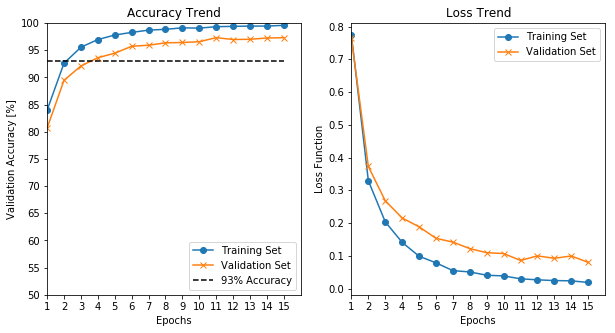

In [15]:
#Plot Validation accuracy
plt.figure(figsize = (10,5))
plt.subplot(1,2,1)
plt.plot(range(1,EPOCHS+1), train_accuracy, '-o', label = 'Training Set')
plt.plot(range(1,EPOCHS+1), valid_accuracy, '-x', label = "Validation Set")
plt.plot(range(1,EPOCHS+1), [93]*EPOCHS, '--k', label = '93% Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy [%]')
plt.xlim(1, EPOCHS+1)
plt.ylim(50,100)
plt.xticks(np.arange(1, EPOCHS+1, 1))
plt.yticks(np.arange(50,105,5))
plt.title('Accuracy Trend')
plt.legend(loc = 'lower right')
plt.subplot(1,2,2)
plt.plot(range(1, EPOCHS+1), train_loss, '-o', label = 'Training Set')
plt.plot(range(1, EPOCHS+1), valid_loss, '-x', label = 'Validation Set')
plt.xlabel('Epochs')
plt.ylabel('Loss Function')
plt.xlim(1, EPOCHS+1)
plt.xticks(np.arange(1, EPOCHS+1, 1))
plt.title('Loss Trend')
plt.legend(loc = 'upper right')
plt.show()

In [16]:
#Evaluate test data
with tf.Session() as sess:
    saver.restore(sess, './LeNet5_Run3')
    test_loss, test_accuracy = evaluate(X_test_processed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Validating & calculating loss...
Test Accuracy = 0.964


In [17]:
#Calculate predictions on the test split
test_soft_max = tf.nn.softmax(logits)
top1 = tf.nn.top_k(test_soft_max, 1)
with tf.Session() as sess:
    saver.restore(sess, './LeNet5_Run3')
    test_split_predictions = sess.run(top1, feed_dict={x: X_test_processed, y: y_test, keep_prob: 1})


In [18]:
from sklearn import metrics
test_predictions = test_split_predictions[1]

#Let's calculate precision & recall
precision = metrics.precision_score(y_test, test_predictions, average=None)
recall = metrics.recall_score(y_test, test_predictions, average=None)

print("Traffic Sign Label                                  # of samples Precision    Recall\n")
for i in range(len(traffic_sign_labels)):
    print("{0:<50}: {1:8d} {2:10.2f}% {3:10.2f}%".format(traffic_sign_labels[i],test_set[i], precision[i]*100, recall[i]*100))


Traffic Sign Label                                  # of samples Precision    Recall

Speed limit (20km/h)                              :       60      95.08%      96.67%
Speed limit (30km/h)                              :      720      92.76%      97.92%
Speed limit (50km/h)                              :      750      95.24%      98.67%
Speed limit (60km/h)                              :      450      95.70%      94.00%
Speed limit (70km/h)                              :      660      98.46%      96.67%
Speed limit (80km/h)                              :      630      94.92%      89.05%
End of speed limit (80km/h)                       :      150      98.63%      96.00%
Speed limit (100km/h)                             :      450      95.46%      98.22%
Speed limit (120km/h)                             :      450      97.70%      94.22%
No passing                                        :      480      99.38%     100.00%
No passing for vehicles over 3.5 metric tons      :      660    

---
## 5. Model Testing

### 5.1 Test Image Visualization

The test images array is: (13, 32, 32, 3)
The test labels array is: (13,)
Let's take a look at all the resized images and their labels:


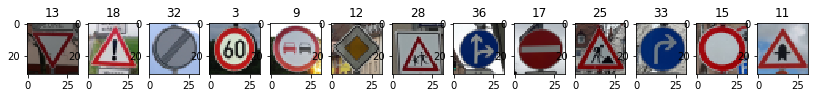

In [32]:
import matplotlib.image as mpimg
import re
from glob import glob

#Import images
test_images = np.empty([13,32,32,3], dtype = np.uint8)
test_labels = np.empty([13], dtype = int)

for i, filename in enumerate(glob('.\\test_images\*.jpg')):
    image = mpimg.imread(filename)
    image = cv2.resize(image, (32,32), interpolation=cv2.INTER_AREA)
    test_images[i] = image
    test_labels[i] = re.findall(r'\d+', filename)[1]

print("The test images array is:", test_images.shape)
print("The test labels array is:", test_labels.shape)
print("Let's take a look at all the resized images and their labels:")

plt.figure(figsize=(14,2))
for i in range(test_images.shape[0]):
    plt.subplot(1,test_images.shape[0],i+1)
    plt.imshow(test_images[i])
    plt.title("{:d}".format(test_labels[i]))
plt.show()

### 5.2 Test Image Predictions

In [20]:
#Process the images
test_images_gray = grayscale(test_images)
test_images_clahe = clahe_equalize(test_images_gray)
test_images_clahe_RGB = clahe_equalize_RGB(test_images)
test_images_merge = merge_channels(test_images_clahe, test_images_clahe_RGB)

mean_test = np.mean(test_images_merge)
std_test = np.std(test_images_merge)

test_images_processed = normalize(test_images_merge, mean_test, std_test)

100%|███████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 12939.24it/s]


In [21]:
#Calculate predictions
soft_max = tf.nn.softmax(logits)
top5 = tf.nn.top_k(soft_max, 5)

with tf.Session() as sess:
    saver.restore(sess, './LeNet5_Run3')
    predictions = sess.run(top5, feed_dict={x: test_images_processed, y: test_labels, keep_prob: 1})


### 5.3 Test Image Performance

In [22]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
with tf.Session() as sess:
    saver.restore(sess, './LeNet5_Run3')
    test_images_loss, test_images_accuracy = evaluate(test_images_processed, test_labels)
    print("Test Image Accuracy = {:.3f}".format(test_images_accuracy))

Validating & calculating loss...
Test Image Accuracy = 1.000


Top 5 Softmax Probabilities for Test Images

Let's visualize the predictions instead of printing them.
On the left is the probability of each top-5 label. The title of the barchart represents the prediction.
On the right is the actual sign and label


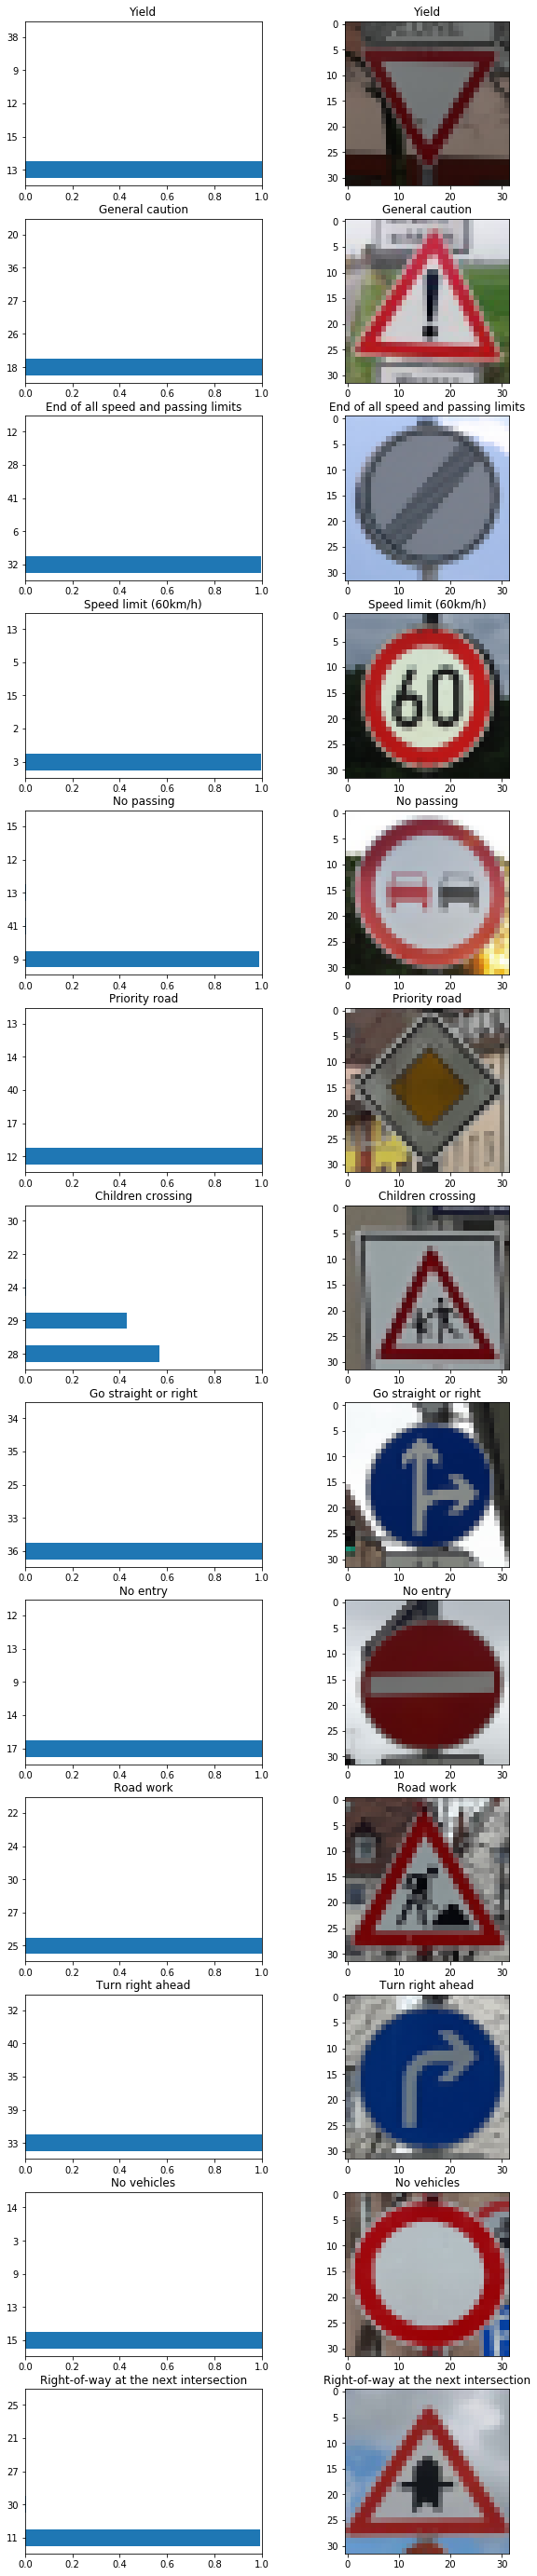

In [25]:
prob_predict, label_predict = predictions[0], predictions[1]

print("Let's visualize the predictions instead of printing them.")
print("On the left is the probability of each top-5 label. The title of the barchart represents the prediction.")
print("On the right is the actual sign and label")
fig = plt.figure(figsize=(10,50))
for i in range(13):
    ax = plt.subplot(13,2,2*i+1)
    plt.barh(range(5), prob_predict[i], height = 0.5)
    ax.set_yticks(range(5))
    ax.set_xlim([0,1])
    ax.set_yticklabels(label_predict[i])
    plt.title("{}".format(traffic_sign_labels[label_predict[i,0]]))
    plt.subplot(13,2,2*i+2)
    plt.imshow(test_images[i])
    plt.title(traffic_sign_labels[test_labels[i]])
plt.show()
fig.savefig('softmax.png', bbox_inches='tight')

---
## 6. Visualizing the Neural Network

In [60]:
# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob: 1})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

Let's take a look at an unprocessed image


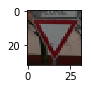

In [61]:
print("Let's take a look at an unprocessed image")
plt.figure(figsize=(1,1))
plt.imshow(test_images[0])
plt.show()
#Re-shape processed image to (1,32,32,4)
image_input = np.expand_dims(test_images_processed[0], 0)

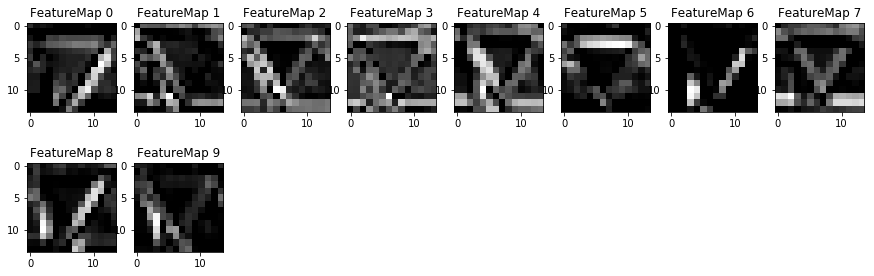

In [64]:
#Visualize feature maps for 1st conv layer. Depth is 10.
with tf.Session() as sess:
    saver.restore(sess, './LeNet5_Run3')
    outputFeatureMap(image_input, conv1)

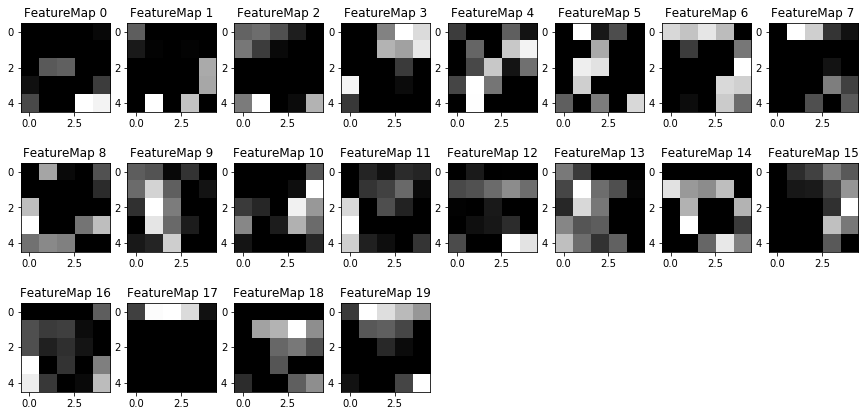

In [65]:
#Visualize feature maps for 2nd conv layer. Depth is 20.
with tf.Session() as sess:
    saver.restore(sess, './LeNet5_Run3')
    outputFeatureMap(image_input, conv2)